## First try at getting some data

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [41]:
#Essentials
import numpy as np
import pandas as pd
import pickle
import re

#API imports
from sodapy import Socrata

#SQL related
import psycopg2
import sqlite3
from sqlalchemy import create_engine
import pandas.io.sql as pd_sql

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import shapely
from shapely.geometry import Point
# import contextily as ctx

#Regression imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn import feature_selection as f_select
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

from sklearn.pipeline import make_pipeline

%matplotlib inline

### Load all the data into an SQL database

In [42]:
# Set up the database connection
conn = psycopg2.connect(dbname="taxi_rides_db", user="auste_m")

In [4]:
# CREATE TABLE taxi_rides (
#                             trip_id TEXT, 
#                             taxi_id TEXT, 
#                             trip_start_timestamp TIMESTAMP,
#                             trip_end_timestamp TIMESTAMP,
#                             trip_seconds INT,
#                             trip_miles FLOAT,
#                             pickup_census_tract TEXT,
#                             pickup_community_area TEXT,
#                             dropoff_census_tract TEXT,
#                             dropoff_community_area TEXT,
#                             fare TEXT,
#                             tips TEXT,
#                             tolls TEXT,
#                             extras TEXT,
#                             trip_total TEXT,
#                             payment_type TEXT,
#                             company TEXT,
#                             pickup_centroid_latitude FLOAT,
#                             pickup_centroid_longitude FLOAT,
#                             pickup_centroid_location TEXT,
#                             dropoff_centroid_latitude FLOAT,
#                             dropoff_centroid_longitude FLOAT,
#                             dropoff_centroid_location TEXT
#                         );

In [5]:
# COPY taxi_rides from '/home/ubuntu/Passion_Project/Taxi_Trips.csv' DELIMITER ',' CSV HEADER;
# COPY taxi_rides from '/home/ubuntu/Passion_Project/Taxi_Trips_2016.csv' DELIMITER ',' CSV HEADER;

In [6]:
# CREATE TABLE chicago_weather(
#                                 station TEXT,
#                                 name TEXT, 
#                                 latitude FLOAT,
#                                 longitude FLOAT,
#                                 elevation FLOAT,
#                                 date TIMESTAMP, 
#                                 avg_daily_wind_speed FLOAT,
#                                 peak_gust_time FLOAT,
#                                 precipitation_mm FLOAT,
#                                 snowfall_mm FLOAT,
#                                 snowdepth_mm FLOAT,
#                                 avg_temp_f INT,
#                                 fog INT,
#                                 heavy_fog INT,
#                                 thunder INT,
#                                 sleet INT,
#                                 hail INT, 
#                                 glaze INT,
#                                 smoke INT,
#                                 drifting_snow INT, 
#                                 mist INT,
#                                 drizzle INT,
#                                 rain INT,
#                                 freezing_rain INT,
#                                 snow INT,
#                                 unkwn_precipitation INT,
#                                 ice_fog INT
#                                  );

In [7]:
# COPY chicago_weather FROM '/home/ubuntu/Chicago_Historical_Weather_Dataset.csv' DELIMITER ',' CSV HEADER;

In [44]:
taxi_rides_query = """SELECT * FROM taxi_rides WHERE trip_start_timestamp BETWEEN '2016-02-01' AND '2016-02-29';""" 
weather_query = """SELECT * FROM chicago_weather WHERE date BETWEEN '2016-02-01' AND '2016-02-29';"""

taxi_weather_query = """SELECT TR.trip_start_timestamp,
                                TR.trip_end_timestamp,
                                TR.trip_seconds,
                                TR.trip_miles,
                                TR.pickup_community_area,
                                TR.dropoff_community_area,
                                TR.fare,
                                TR.tips,
                                TR.tolls,
                                TR.extras,
                                TR.trip_total,
                                TR.payment_type,
                                TR.pickup_centroid_latitude,
                                TR.pickup_centroid_longitude,
                                TR.pickup_centroid_location,
                                TR.dropoff_centroid_latitude,
                                TR.dropoff_centroid_longitude,
                                TR.dropoff_centroid_location,
                                CW.avg_daily_wind_speed,
                                CW.avg_temp_f,
                                CASE WHEN CW.fog = 1 OR CW.heavy_fog = 1 OR ice_fog = 1 OR mist = 1 THEN 1 ELSE 0 END [fog],
                                CASE WHEN CW.rain OR CW.drizzle = 1 OR CW.hail = 1 THEN 1 ELSE 0 END [rain]
                                CASE WHEN CW.snow = 1 OR CW.freezing_rain = 1 OR drifting_snow = 1 THEN 1 ELSE 0 END [snow]
                                
                        FROM taxi_rides as TR
                        LEFT JOIN chicago_weather as CW
                        ON CAST(TR.trip_start_timestamp AS DATE) = CAST(date AS DATE)
                        WHERE trip_start_timestamp BETWEEN '2016-02-01' AND '2016-02-29';""" 

In [9]:
# test_rides = """SELECT MIN(trip_start_timestamp) FROM taxi_rides;"""
# pd.read_sql_query(test_rides, con=conn)

In [45]:
#approx. 30min to load the whole of 2016 data
taxi_weather_df = pd.read_sql_query(taxi_weather_query, con=conn)

DatabaseError: Execution failed on sql 'SELECT TR.trip_start_timestamp,
                                TR.trip_end_timestamp,
                                TR.trip_seconds,
                                TR.trip_miles,
                                TR.pickup_community_area,
                                TR.dropoff_community_area,
                                TR.fare,
                                TR.tips,
                                TR.tolls,
                                TR.extras,
                                TR.trip_total,
                                TR.payment_type,
                                TR.pickup_centroid_latitude,
                                TR.pickup_centroid_longitude,
                                TR.pickup_centroid_location,
                                TR.dropoff_centroid_latitude,
                                TR.dropoff_centroid_longitude,
                                TR.dropoff_centroid_location,
                                CW.avg_daily_wind_speed,
                                CW.avg_temp_f,
                                CASE WHEN CW.fog = 1 OR CW.heavy_fog = 1 OR ice_fog = 1 OR mist = 1 THEN 1 ELSE 0 END [fog],
                                CASE WHEN CW.rain OR CW.drizzle = 1 OR CW.hail = 1 THEN 1 ELSE 0 END [rain]
                                CASE WHEN CW.snow = 1 OR CW.freezing_rain = 1 OR drifting_snow = 1 THEN 1 ELSE 0 END [snow]
                                
                        FROM taxi_rides as TR
                        LEFT JOIN chicago_weather as CW
                        ON CAST(TR.trip_start_timestamp AS DATE) = CAST(date AS DATE)
                        WHERE trip_start_timestamp BETWEEN '2016-02-01' AND '2016-02-29';': syntax error at or near "["
LINE 21: ..._fog = 1 OR ice_fog = 1 OR mist = 1 THEN 1 ELSE 0 END [fog],
                                                                  ^


In [14]:
taxi_weather_df.head()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,pickup_community_area,dropoff_census_tract,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
0,6ac808261853e84e4ba2d6fb9eda562f1bb6a474,a327a815ec47517af7b98478563a9d330f9e1d1b5c1da2...,2016-02-19 23:45:00,2016-02-19 23:45:00,0.0,0.0,None,None,None,None,...,$0.00,$2.00,Cash,None,NaN,NaN,None,NaN,NaN,None
1,70b3336ad32c6567ce68481f01df1c08300629dd,9e923176b8dde7f338d9aeb93b1c45d198ddf767ac6985...,2016-02-19 16:45:00,2016-02-19 16:45:00,0.0,0.0,None,None,None,None,...,$0.00,$6.25,Cash,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,None,NaN,NaN,None
2,742f9ee1fd009608483003471f7d5f588f9c8769,a12c883fec0aa569be9761fda97c2be806723243ab9090...,2016-02-10 20:45:00,2016-02-10 20:45:00,0.0,0.0,None,None,None,None,...,$0.00,$51.90,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,None,NaN,NaN,None
3,01898f5cf6a355d024189b29b43ab626429e13aa,ba5412a204ac0bee645a854a7eb69abd3df912fbaa9857...,2016-02-15 06:15:00,2016-02-15 06:15:00,300.0,0.8,None,None,None,None,...,$0.00,$7.50,Credit Card,None,NaN,NaN,None,NaN,NaN,None
4,0176ae15075ad0765349bf8504986825b483c7f0,49c7419cb833c4208dbc10ac896577053817af7ced62eb...,2016-02-19 19:30:00,2016-02-19 19:30:00,0.0,0.0,None,None,None,None,...,$0.00,$9.00,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,None,NaN,NaN,None


In [40]:
taxi_weather_df[taxi_weather_df['pickup_community_area'].isnull()].info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 708015 entries, 0 to 1697004
Data columns (total 23 columns):
trip_id                       708015 non-null object
taxi_id                       708015 non-null object
trip_start_timestamp          708015 non-null datetime64[ns]
trip_end_timestamp            707920 non-null datetime64[ns]
trip_seconds                  707889 non-null float64
trip_miles                    708013 non-null float64
pickup_census_tract           10146 non-null object
pickup_community_area         0 non-null object
dropoff_census_tract          425212 non-null object
dropoff_community_area        396866 non-null object
fare                          708010 non-null object
tips                          708010 non-null object
tolls                         708010 non-null object
extras                        708010 non-null object
trip_total                    708010 non-null object
payment_type                  708015 non-null object
company                     

In [15]:
taxi_weather_df.columns

Index(['trip_id', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp',
       'trip_seconds', 'trip_miles', 'pickup_census_tract',
       'pickup_community_area', 'dropoff_census_tract',
       'dropoff_community_area', 'fare', 'tips', 'tolls', 'extras',
       'trip_total', 'payment_type', 'company', 'pickup_centroid_latitude',
       'pickup_centroid_longitude', 'pickup_centroid_location',
       'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
       'dropoff_centroid_location'],
      dtype='object')

### Drop unnecessary columns and update geolocation point columns for pickup and dropoff using shapely

In [19]:
taxi_weather_df.drop(columns=['trip_id','taxi_id', 'company', 'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area','dropoff_community_area'], inplace=True)

In [20]:
#replace pickup_centroid_location and dropoff_centroid_location columns with point coordinates using shapely
pickup_geopoint = list(zip(taxi_weather_df['pickup_centroid_longitude'], taxi_weather_df['pickup_centroid_latitude']))
dropoff_geopoint = list(zip(taxi_weather_df['dropoff_centroid_longitude'], taxi_weather_df['dropoff_centroid_latitude']))

taxi_weather_df['pickup_centroid_location'] = pickup_geopoint
taxi_weather_df['dropoff_centroid_location'] = dropoff_geopoint

taxi_weather_df['pickup_centroid_location'] = taxi_weather_df['pickup_centroid_location'].apply(Point)
taxi_weather_df['dropoff_centroid_location'] = taxi_weather_df['dropoff_centroid_location'].apply(Point)


In [21]:
taxi_weather_df.head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
0,2016-02-19 23:45:00,2016-02-19 23:45:00,0.0,0.0,$2.00,$0.00,$0.00,$0.00,$2.00,Cash,NaN,NaN,POINT (nan nan),NaN,NaN,POINT (nan nan)
1,2016-02-19 16:45:00,2016-02-19 16:45:00,0.0,0.0,$6.25,$0.00,$0.00,$0.00,$6.25,Cash,NaN,NaN,POINT (nan nan),NaN,NaN,POINT (nan nan)
2,2016-02-10 20:45:00,2016-02-10 20:45:00,0.0,0.0,$43.25,$8.65,$0.00,$0.00,$51.90,Credit Card,NaN,NaN,POINT (nan nan),NaN,NaN,POINT (nan nan)
3,2016-02-15 06:15:00,2016-02-15 06:15:00,300.0,0.8,$5.50,$2.00,$0.00,$0.00,$7.50,Credit Card,NaN,NaN,POINT (nan nan),NaN,NaN,POINT (nan nan)
4,2016-02-19 19:30:00,2016-02-19 19:30:00,0.0,0.0,$7.50,$1.50,$0.00,$0.00,$9.00,Credit Card,NaN,NaN,POINT (nan nan),NaN,NaN,POINT (nan nan)


In [22]:
# taxi_weather_df['pickup_centroid_location'].dropna(inplace=True)
# taxi_weather_df['dropoff_centroid_location'].dropna(inplace=True)

In [23]:
taxi_weather_gdf = gpd.GeoDataFrame(taxi_weather_df, geometry='pickup_centroid_location')

In [24]:
taxi_weather_gdf.tail()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
1697004,2016-02-16 18:15:00,2016-02-16 18:30:00,900.0,1.30,$9.50,$0.00,$0.00,$1.00,$10.50,Cash,NaN,NaN,POINT (nan nan),NaN,NaN,POINT (nan nan)
1697005,2016-02-04 08:15:00,2016-02-04 08:30:00,420.0,0.94,$6.75,$0.00,$0.00,$0.00,$6.75,Cash,41.885300,-87.642808,POINT (-87.64280846600001 41.885300022),41.884987,-87.620993,POINT (-87.62099291299999 41.884987192)
1697006,2016-02-24 06:30:00,2016-02-24 06:30:00,120.0,0.22,$4.00,$0.00,$0.00,$0.00,$4.00,Cash,41.898332,-87.620763,POINT (-87.620762865 41.898331794),41.898332,-87.620763,POINT (-87.620762865 41.898331794)
1697007,2016-02-10 17:45:00,2016-02-10 17:45:00,240.0,0.65,$5.50,$0.00,$0.00,$0.00,$5.50,Cash,41.902788,-87.626146,POINT (-87.62614558999999 41.902788048),41.899156,-87.626211,POINT (-87.626210532 41.899155613)
1697008,2016-02-26 14:30:00,2016-02-26 15:15:00,2160.0,16.41,$41.25,$11.31,$0.00,$4.00,$56.56,Credit Card,41.979071,-87.903040,POINT (-87.90303966099999 41.97907082),41.885300,-87.642808,POINT (-87.64280846600001 41.885300022)


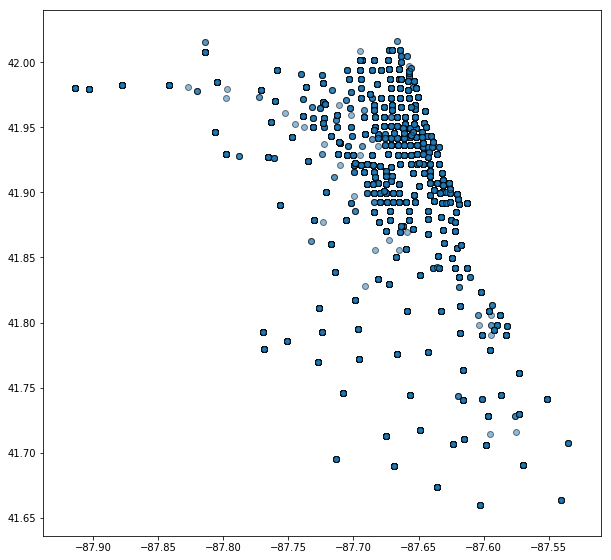

In [25]:
# df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# # We restrict to North America.
# ax = world[world.continent == 'North America'].plot(
#     color='white', edgecolor='blue')

# # We can now plot our GeoDataFrame.
# taxi_weather_gdf.plot(ax=ax, color='red')
# plt.show()

taxi_weather_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k');

**Let's do the same for weather dataframe**

In [26]:
#replace pickup_centroid_location and dropoff_centroid_location columns with point coordinates using shapely
weather_geopoint = list(zip(cc_weather_df['longitude'], cc_weather_df['latitude']))
cc_weather_df['geopoint'] = weather_geopoint
cc_weather_df['geopoint'] = cc_weather_df['geopoint'].apply(Point)


In [27]:
cc_weather_gdf = gpd.GeoDataFrame(cc_weather_df, geometry='geopoint')

In [28]:
cc_weather_gdf.head()

,station,name,latitude,longitude,elevation,date,avg_daily_wind_speed,peak_gust_time,precipitation_mm,snowfall_mm,...,smoke,drifting_snow,mist,drizzle,rain,freezing_rain,snow,unkwn_precipitation,ice_fog,geopoint
0,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",41.995,-87.9336,201.8,2016-02-01,4.92,None,0.00,0.0,...,NaN,None,None,None,None,None,None,None,None,POINT (-87.9336 41.995)
1,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",41.995,-87.9336,201.8,2016-02-02,11.41,None,0.79,0.0,...,1.0,None,None,None,None,None,None,None,None,POINT (-87.9336 41.995)
2,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",41.995,-87.9336,201.8,2016-02-03,13.42,None,0.02,0.0,...,NaN,None,None,None,None,None,None,None,None,POINT (-87.9336 41.995)
3,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",41.995,-87.9336,201.8,2016-02-04,9.40,None,0.00,0.0,...,NaN,None,None,None,None,None,None,None,None,POINT (-87.9336 41.995)
4,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",41.995,-87.9336,201.8,2016-02-05,6.71,None,0.00,0.0,...,NaN,None,None,None,None,None,None,None,None,POINT (-87.9336 41.995)


## Cleaning Fun

### Helper Functions

In [29]:
def dollar_to_float(string):
    """Converts text columns with dollar sign into floats (after removing the currency sign)"""
    pattern = re.compile('\$+')
    old_value = string
    new_value = 0.0
    try:
        new_value = re.sub(pattern, '', old_value)
        new_value = float(new_value)
    except:
        ValueError
    return new_value



In [30]:
taxi_weather_gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697009 entries, 0 to 1697008
Data columns (total 16 columns):
trip_start_timestamp          datetime64[ns]
trip_end_timestamp            datetime64[ns]
trip_seconds                  float64
trip_miles                    float64
fare                          object
tips                          object
tolls                         object
extras                        object
trip_total                    object
payment_type                  object
pickup_centroid_latitude      float64
pickup_centroid_longitude     float64
pickup_centroid_location      object
dropoff_centroid_latitude     float64
dropoff_centroid_longitude    float64
dropoff_centroid_location     object
dtypes: datetime64[ns](2), float64(6), object(8)
memory usage: 207.2+ MB


In [31]:
#Cleaning the money values
taxi_weather_gdf['fare'] = [dollar_to_float(fare) for fare in taxi_weather_gdf['fare']]
taxi_weather_gdf['tips'] = [dollar_to_float(fare) for fare in taxi_weather_gdf['tips']]
taxi_weather_gdf['tolls'] = [dollar_to_float(fare) for fare in taxi_weather_gdf['tolls']]
taxi_weather_gdf['extras'] = [dollar_to_float(fare) for fare in taxi_weather_gdf['extras']]
taxi_weather_gdf['trip_total'] = [dollar_to_float(fare) for fare in taxi_weather_gdf['trip_total']]

#Remove records with NaN values 


In [32]:
#Recalculate the base fare


In [33]:
taxi_weather_gdf.head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
0,2016-02-19 23:45:00,2016-02-19 23:45:00,0.0,0.0,2.00,0.00,0.0,0.0,2.00,Cash,NaN,NaN,POINT (nan nan),NaN,NaN,POINT (nan nan)
1,2016-02-19 16:45:00,2016-02-19 16:45:00,0.0,0.0,6.25,0.00,0.0,0.0,6.25,Cash,NaN,NaN,POINT (nan nan),NaN,NaN,POINT (nan nan)
2,2016-02-10 20:45:00,2016-02-10 20:45:00,0.0,0.0,43.25,8.65,0.0,0.0,51.90,Credit Card,NaN,NaN,POINT (nan nan),NaN,NaN,POINT (nan nan)
3,2016-02-15 06:15:00,2016-02-15 06:15:00,300.0,0.8,5.50,2.00,0.0,0.0,7.50,Credit Card,NaN,NaN,POINT (nan nan),NaN,NaN,POINT (nan nan)
4,2016-02-19 19:30:00,2016-02-19 19:30:00,0.0,0.0,7.50,1.50,0.0,0.0,9.00,Credit Card,NaN,NaN,POINT (nan nan),NaN,NaN,POINT (nan nan)


In [37]:
taxi_weather_gdf[taxi_weather_gdf['pickup_centroid_longitude'].isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287350 entries, 0 to 1697004
Data columns (total 16 columns):
trip_start_timestamp          287350 non-null datetime64[ns]
trip_end_timestamp            287346 non-null datetime64[ns]
trip_seconds                  287331 non-null float64
trip_miles                    287349 non-null float64
fare                          287350 non-null float64
tips                          287350 non-null float64
tolls                         287350 non-null float64
extras                        287350 non-null float64
trip_total                    287350 non-null float64
payment_type                  287350 non-null object
pickup_centroid_latitude      0 non-null float64
pickup_centroid_longitude     0 non-null float64
pickup_centroid_location      287350 non-null object
dropoff_centroid_latitude     9638 non-null float64
dropoff_centroid_longitude    9638 non-null float64
dropoff_centroid_location     287350 non-null object
dtypes: datetime64[ns](2), 

In [ ]:
taxi_weather_gdf[taxi_weather_gdf['trip_seconds'].isnull()].count()
taxi_weather_gdf[taxi_weather_gdf['trip_miles'].isnull()].count()

#Not Good!!!!
# taxi_weather_df[(taxi_weather_df['trip_seconds'] == 0.0) & (taxi_weather_df['trip_miles'] == 0.0)].count()

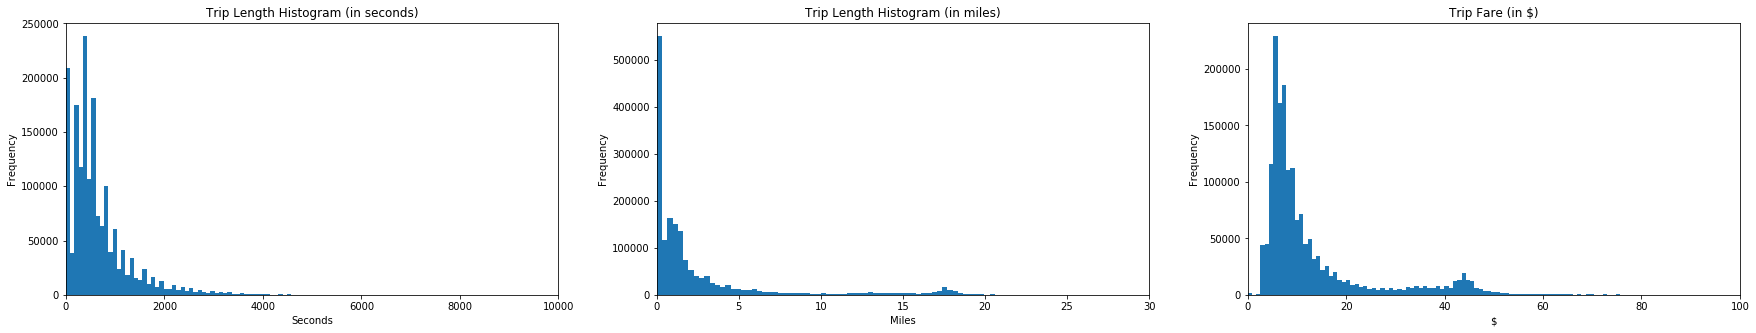

In [35]:
#Let's explore the distribution of variables of interest
plt.figure(figsize=(30, 5))

plt.subplot(1, 3, 1)
plt.hist(taxi_weather_gdf['trip_seconds'].dropna(), bins=1000)
plt.title('Trip Length Histogram (in seconds)')
plt.xlim(xmin=0, xmax=10000)
plt.xlabel('Seconds')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(taxi_weather_gdf['trip_miles'].dropna(), bins=10000)
plt.title('Trip Length Histogram (in miles)')
plt.xlim(xmin=0, xmax=30)
plt.xlabel('Miles')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(taxi_weather_gdf['fare'], bins=10000)
plt.title('Trip Fare (in $)')
plt.xlim(xmin=0, xmax=100)
plt.xlabel('$')
plt.ylabel('Frequency');